# Table of Contents:

0. **Data preparation**
1. **Simple strategy backtest**
2. **Basket Trading test**
3. **Pairs Trading (cointegration) test**

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import talib

Populating the interactive namespace from numpy and matplotlib


In [2]:
#crops dataframe to needed date interval
def crop(df, start='2016-03-01 10:00:00', end='2016-09-01 10:00:00'):
    df = df[df[df.dt == start].index[0]:df[df.dt == end].index[0]]
    df.index = pd.RangeIndex(df.shape[0])
    return df

In [3]:
PATH_TO_DATA = os.getcwd()
PATH_TO_DATA = PATH_TO_DATA[:-PATH_TO_DATA[::-1].find("/")]
PATH_TO_DATA += "data/shares/"
df_emr = crop(pd.read_csv(PATH_TO_DATA + "EMR.csv", sep=','))
df_jbl = crop(pd.read_csv(PATH_TO_DATA + "JBL.csv", sep=','))
df_met = crop(pd.read_csv(PATH_TO_DATA + "MET.csv", sep=','))
df_see = crop(pd.read_csv(PATH_TO_DATA + "SEE.csv", sep=','))

PATH_TO_DATA += "semiconductors/"
df_mu = crop(pd.read_csv(PATH_TO_DATA + "MU.csv", sep=','))
df_amat = crop(pd.read_csv(PATH_TO_DATA + "AMAT.csv", sep=','))
df_amd = crop(pd.read_csv(PATH_TO_DATA + "AMD.csv", sep=','))
df_intc = crop(pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=','))
df_klac = crop(pd.read_csv(PATH_TO_DATA + "KLAC.csv", sep=','))
df_lrcx = crop(pd.read_csv(PATH_TO_DATA + "LRCX.csv", sep=','))
df_mchp = crop(pd.read_csv(PATH_TO_DATA + "MCHP.csv", sep=','))
df_nvda = crop(pd.read_csv(PATH_TO_DATA + "NVDA.csv", sep=','))
df_ter = crop(pd.read_csv(PATH_TO_DATA + "TER.csv", sep=','))

dfs = [df_emr, df_jbl, df_met, df_see, df_mu, 
       df_amat, df_amd, df_intc, df_klac, 
       df_lrcx, df_mchp, df_nvda, df_ter]

In [4]:
print(df_emr.shape)
df_emr.head()

(3354, 6)


,dt,open,high,low,close,volume
0,2016-03-01 10:00:00,49.2596,49.42,49.21,49.390,249294
1,2016-03-01 10:15:00,49.4200,49.69,49.38,49.680,434581
2,2016-03-01 10:30:00,49.6900,49.84,49.59,49.773,544205
3,2016-03-01 10:45:00,49.7800,49.84,49.69,49.730,598212
4,2016-03-01 11:00:00,49.7200,49.72,49.59,49.670,667490


<Figure size 1152x576 with 0 Axes>

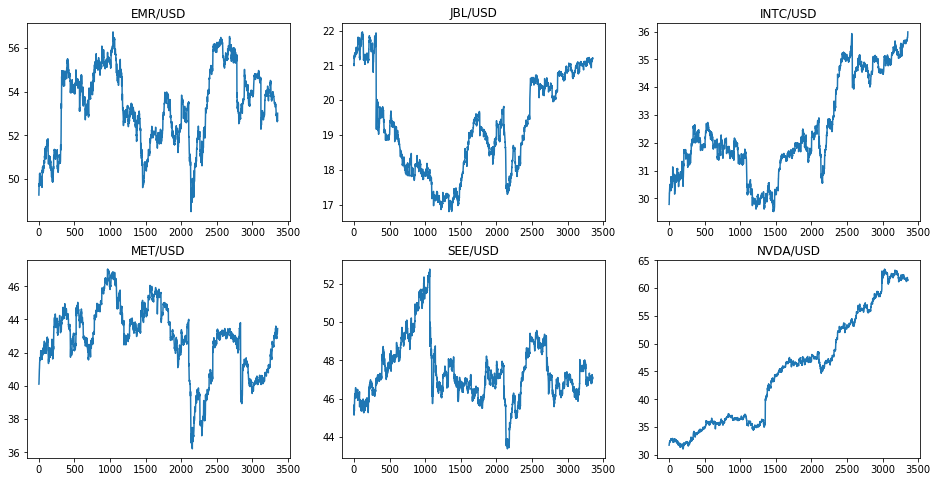

In [5]:
plt.figure(figsize(16,8))
fig, axs = plt.subplots(2, 3)

axs[0,0].plot(range(df_emr.shape[0]), df_emr['open'].values)
axs[0,1].plot(range(df_jbl.shape[0]), df_jbl['open'].values)
axs[1,0].plot(range(df_met.shape[0]), df_met['open'].values)
axs[1,1].plot(range(df_see.shape[0]), df_see['open'].values)
axs[0,2].plot(range(df_intc.shape[0]), df_intc['open'].values)
axs[1,2].plot(range(df_nvda.shape[0]), df_nvda['open'].values)

axs[0,0].title.set_text('EMR/USD')
axs[0,1].title.set_text('JBL/USD')
axs[1,0].title.set_text('MET/USD')
axs[1,1].title.set_text('SEE/USD')
axs[0,2].title.set_text('INTC/USD')
axs[1,2].title.set_text('NVDA/USD')

plt.show()

# Simple strategy backtest

**Note:** Class for backtesting can be found in *[backtest.py](https://github.com/snp600/trading-sandbox/blob/master/backtesting/backtest.py)*.

**Strategy:**
* Buy: RSI_14 < 30
* Sell: RSI_14 > 70
* Hold: RSI_14 $\in$ [30, 70]

In [6]:
import backtest

#add signals to buy/sell to all dfs
for df in dfs:
    rsi = talib.RSI(df['open'].values, timeperiod=14)
    df['custom_signal'] = backtest.IndicatorMarks().rsi_marks(rsi) #'buy' if RSI < 30 and 'sell' if RSI > 70
    
plt.figure(figsize(10,4));

<Figure size 720x288 with 0 Axes>

**Sharpe = 2.6** -- seems to be good but it is always needed to compare with some benchmark

{'profit factor': 1.444, 'sharpe ratio': 2.602, 'max drawdown': '0.1%'}


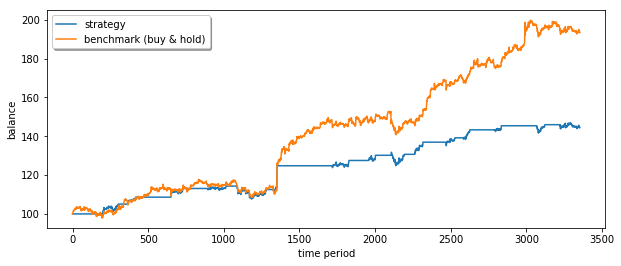

In [7]:
sib = backtest.SingleInstrumentBacktest(df_nvda)
sib.full_backtest(show_balance=False);
sib.show_performance(show_benchmark=True)

{'profit factor': 0.899, 'sharpe ratio': -0.693, 'max drawdown': '16.1%'}


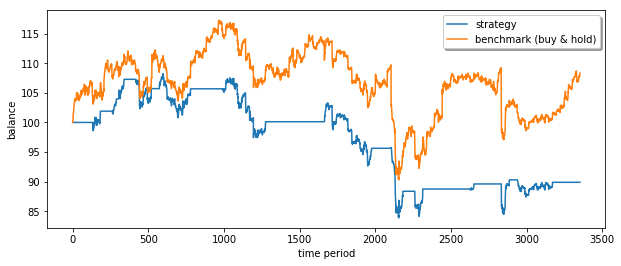

In [8]:
#another example -- just for test
sib = backtest.SingleInstrumentBacktest(df_met)
sib.full_backtest(show_balance=False);
sib.show_performance(show_benchmark=True)

### Testing on diversified portfolio

In [9]:
#evaluating average profit factor for all the instruments
def trade_everything(dfs, stoploss=1000, takeprofit=1000):
    periods = dfs[0]['open'].shape[0]
    balance = np.zeros(periods)
    avg_profit_factor = 0
    for df in dfs:
        sib = backtest.SingleInstrumentBacktest(df, stoploss=stoploss, takeprofit=takeprofit)
        balance += sib.full_backtest(print_metrics=False, show_balance=False)[0]
        metrics = sib.get_metrics()
        avg_profit_factor += metrics['profit factor']
    balance /= len(dfs)
    avg_profit_factor /= len(dfs)
    print(round(avg_profit_factor, 3))

In [10]:
#evaluating benchmark (buy & hold) profit factor
benchmark_profit_factor = 0
for df in dfs:
    prices = df['open'].values
    benchmark_profit_factor += prices[-1] / prices[0]
benchmark_profit_factor /= len(dfs)

In [11]:
#period: 6 months, 13 shares
trade_everything(dfs) #no stoploss/takeprofit
trade_everything(dfs, takeprofit=0.05) #5% takeprofit
trade_everything(dfs, takeprofit=0.08) #8% takeprofit
trade_everything(dfs, stoploss=0.03) #3% stoploss
trade_everything(dfs, stoploss=0.05) #5% stoploss
trade_everything(dfs, stoploss=0.03, takeprofit=0.08) #3% stoploss and 8% takeprofit
trade_everything(dfs, stoploss=0.05, takeprofit=0.08) #5% stoploss and 8% takeprofit
print(str(round(benchmark_profit_factor, 3)) + " -- benchmark (buy & hold) profit factor")

1.157
1.159
1.157
1.124
1.105
1.123
1.104
1.431 -- benchmark (buy & hold) profit factor


**Summary:**

* *Class for backtesting works*

* For diversified portfolio this simple strategy [buy: 'RSI < 30'; sell: 'RSI > 70'] also does not work in this case: many instruments have up-trend 

* For such strategy it seems that applying stoplosses is not effective

# Basket Trading test

**Algorithm:**

1) Every *rebalance* periods a portfolio is rebalanced:
* Instruments are sorted [ranked] according to some criteria (in example below it is ascending RSI_14 -- just for test)
* top half's signals are assigned as 'buy' and the rest are 'sell'

2) All the instruments are backtested with recorded buy/sell signals

In [12]:
class BasketTrading():
    
    prices = None
    factors = []
    ranks = None
    rebalance = 20 #each 'rebalance' periods portfolio is rebalanced
    
    
    def __init__(self, prices, rebalance=20):
        self.prices = prices
        self.form_factors()
        self.rebalance = rebalance
    
    #rsi here is just for test
    def factor(self, p):
        return talib.RSI(p, timeperiod=14)
    
    #factors for each instrument
    def form_factors(self):
        for p in self.prices:
            self.factors.append(self.factor(p))
            
    #forms buy/sell signal according to ranks        
    def form_ranks(self):
        n = len(self.prices)
        m = len(self.prices[0])
        self.ranks = [['hold'] * m] * n #ranks for each instrument at each period
        self.ranks = np.array(self.ranks)
        for i in range(14, m): #'14' to exclude first 14 'None's because of RSI window 
            if (i % self.rebalance == 0):
                temp = []
                for j in range(n):
                    temp.append(self.factors[j][i])
                temp_df = pd.DataFrame(index=range(n), columns=['factors'])
                temp_df['factors'] = temp
                temp_df = temp_df.sort_values('factors')
            
                for ind in temp_df.index[:int(n/2)+1]: #top half
                    self.ranks[ind][i] = 'buy'
                for ind in temp_df.index[int(n/2)+1:]:
                    self.ranks[ind][i] = 'sell'
        return self.ranks
    
    
    #backtest for all instruments using buy/sell signals based on their ranks
    def trade(self, print_metrics=True):
        balances = []
        for i in range(len(self.prices)):
            df = pd.DataFrame(index = range(len(self.prices[i])), columns=['open', 'custom_signal'])
            df['open'] = self.prices[i]
            df['custom_signal'] = self.ranks[i]
            sib = backtest.SingleInstrumentBacktest(df, stoploss=1000, takeprofit=1000)
            balances.append((sib.full_backtest(show_balance=False, 
                                               print_metrics=print_metrics), 
                             sib.get_metrics()))
        return balances

In [13]:
#backtest all instruments [shares] using buy/sell signal according to their ranks 
open_prices = []
for df in dfs:
    open_prices.append(df['open'].values)

basket_trading = BasketTrading(open_prices)
basket_trading.form_ranks()
balances = basket_trading.trade()

{'profit factor': 1.089, 'sharpe ratio': 0.799, 'max drawdown': '1.9%'}
{'profit factor': 1.02, 'sharpe ratio': 0.211, 'max drawdown': '13.9%'}
{'profit factor': 1.274, 'sharpe ratio': 1.634, 'max drawdown': '0.2%'}
{'profit factor': 0.996, 'sharpe ratio': 0.053, 'max drawdown': '11.1%'}
{'profit factor': 1.18, 'sharpe ratio': 0.798, 'max drawdown': '15.2%'}
{'profit factor': 1.008, 'sharpe ratio': 0.123, 'max drawdown': '7.9%'}
{'profit factor': 1.573, 'sharpe ratio': 1.365, 'max drawdown': '5.4%'}
{'profit factor': 1.111, 'sharpe ratio': 1.102, 'max drawdown': '2.3%'}
{'profit factor': 1.02, 'sharpe ratio': 0.277, 'max drawdown': '1.9%'}
{'profit factor': 1.08, 'sharpe ratio': 0.689, 'max drawdown': '4.7%'}
{'profit factor': 1.31, 'sharpe ratio': 2.302, 'max drawdown': '0.2%'}
{'profit factor': 1.178, 'sharpe ratio': 1.267, 'max drawdown': '2.6%'}
{'profit factor': 0.976, 'sharpe ratio': -0.151, 'max drawdown': '8.4%'}


In [14]:
#6 months
avg_profit_factor = 0
for x in balances:
    avg_profit_factor += x[1]['profit factor']
print(round(avg_profit_factor / len(balances), 4))

1.1396


**Summary:**

* **Profit factor = 1.14** -- seems to be good, but benchmark "buy and hold" gives **1.43** so it's not.
Need to choose another ranking criteria (sorting by RSI is very naive).

* **It is the main challenge of this strategy: to choose proper ranking criteria.**

* Dependance of average profit factor on *rebalance* hyperparameter seems not sufficient (it slightly grows because of up-trend):

In [15]:
def rebalance_constant_check(open_prices, start=5, end=100, step=10):
    rebalance_values = range(start, end, step)
    avg_profit_factors = []
    for rebalance in rebalance_values:
        basket_trading = BasketTrading(open_prices, rebalance=rebalance)
        basket_trading.form_ranks()
        balances = basket_trading.trade(print_metrics=False)
        avg_profit_factor = 0
        for x in balances:
            avg_profit_factor += x[1]['profit factor']
        avg_profit_factor /= len(balances)
        avg_profit_factors.append(avg_profit_factor)
    
    plt.plot(rebalance_values, avg_profit_factors)
    plt.xlabel('rebalance')
    plt.ylabel('average profit factor')

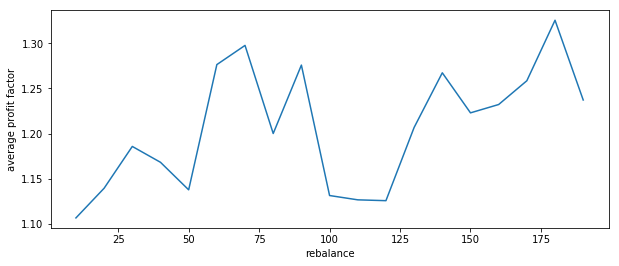

In [16]:
rebalance_constant_check(open_prices, start=10, end=200, step=10)

# Pairs Trading test

In [17]:
from statsmodels.tsa.stattools import coint

def find_cointegrated(prices):
    n = len(dfs)
    cointegrated = []
    train_size = int(len(prices[0]) * 1.0)
    for i in range(n):
        for j in range(i + 1, n):
            score, p, _ = coint(prices[i][:train_size], prices[j][:train_size])
            if p < 0.05:
                cointegrated.append((i, j))
    return cointegrated


prices = []
for df in dfs:
    prices.append(df['open'].values)
    
cointegrated = find_cointegrated(prices)
print(cointegrated) #emr/see and intc/lrcx

[(0, 3), (7, 9)]


In [18]:
print(coint(df_emr['open'].values, df_see['open'].values)[1]) #p-value
print(coint(df_intc['open'].values, df_lrcx['open'].values)[1]) #p-value
#correct

0.019349900600057264
0.02327883091463758


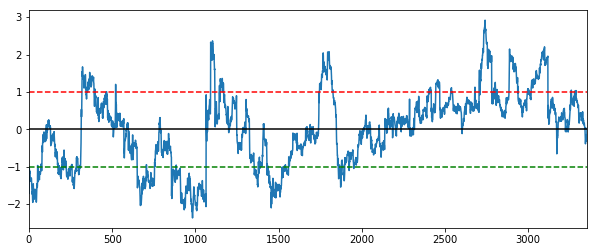

In [19]:
ratios = df_emr['open'] / df_see['open']
zscore = (ratios - ratios.mean()) / np.std(ratios)
zscore.plot()
plt.axhline(zscore.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.show()

**Strategy:**
    LONG *EMR* (and SHORT *SEE*) when $z<-1$ and SHORT *EMR* (and LONG *SEE*) when $z>1$.
    
But it is not possible **can't trade past periods** -- so it is needed to check cointegration on the next periods for these candidates.

In [20]:
df_emr_next = crop(pd.read_csv(PATH_TO_DATA + "EMR.csv", sep=','), 
                    start='2016-09-01 10:00:00', 
                    end='2017-03-01 10:00:00')
df_see_next = crop(pd.read_csv(PATH_TO_DATA + "SEE.csv", sep=','), 
                    start='2016-09-01 10:00:00', 
                    end='2017-03-01 11:15:00')
df_intc_next = crop(pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=','), 
                    start='2016-09-01 10:00:00', 
                    end='2017-03-01 10:00:00')
df_lrcx_next = crop(pd.read_csv(PATH_TO_DATA + "LRCX.csv", sep=','), 
                    start='2016-09-01 10:00:00', 
                    end='2017-03-01 11:15:00')
df_see_next = df_see_next[:3189]
print(coint(df_emr_next['open'].values, df_see_next['open'].values)[1])
print(coint(df_intc_next['open'].values, df_lrcx_next['open'].values)[1])

0.2916524295517621
0.4175500922634981


Unfortunately such pairs are not cointegrated during the next 6 months.

To determine correctness of the strategy it is needed to check, **how often cointegration on some period leads to cointegration on the next period.**

Note: the first periods is like *train* sample and the second is *test*. So will good score on *train* mean good score on *test*?

In [21]:
#crops dataframe to needed date interval
def crop(df, start='2015-03-05 10:00:00', end='2016-10-10 10:00:00'):
    df = df[df[df.dt == start].index[0]:df[df.dt == end].index[0]]
    df.index = pd.RangeIndex(df.shape[0])
    return df

In [22]:
PATH_TO_DATA = os.getcwd()
PATH_TO_DATA = PATH_TO_DATA[:-PATH_TO_DATA[::-1].find("/")]
PATH_TO_DATA += "data/shares/"
df_emr = crop(pd.read_csv(PATH_TO_DATA + "EMR.csv", sep=','))
df_jbl = crop(pd.read_csv(PATH_TO_DATA + "JBL.csv", sep=','))
df_met = crop(pd.read_csv(PATH_TO_DATA + "MET.csv", sep=','))
df_see = crop(pd.read_csv(PATH_TO_DATA + "SEE.csv", sep=','))

PATH_TO_DATA += "semiconductors/"
df_mu = crop(pd.read_csv(PATH_TO_DATA + "MU.csv", sep=','))
df_amat = crop(pd.read_csv(PATH_TO_DATA + "AMAT.csv", sep=','))
df_amd = crop(pd.read_csv(PATH_TO_DATA + "AMD.csv", sep=','))
df_intc = crop(pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=','))
df_klac = crop(pd.read_csv(PATH_TO_DATA + "KLAC.csv", sep=','))
df_lrcx = crop(pd.read_csv(PATH_TO_DATA + "LRCX.csv", sep=','))
df_mchp = crop(pd.read_csv(PATH_TO_DATA + "MCHP.csv", sep=','))
df_nvda = crop(pd.read_csv(PATH_TO_DATA + "NVDA.csv", sep=','))
df_ter = crop(pd.read_csv(PATH_TO_DATA + "TER.csv", sep=','))

dfs = [df_emr, df_jbl, df_met, df_see, df_mu, 
       df_amat, df_amd, df_intc, df_klac, 
       df_lrcx, df_mchp, df_nvda, df_ter]

N = 10000
prices = []
for df in dfs:
    prices.append(df['open'].values[:N])

In [23]:
#returns all cointegrated pairs for each period
def cointegrations_list(prices):
    n = len(dfs)
    cointegrations = []
    train_size = int(len(prices[0]) * 1.0)
    step = 2000 #approx. 4 month
    for k in range(0, 10000, step):
        temp = []
        for i in range(n):
            for j in range(i + 1, n):
                score, p, _ = coint(prices[i][k:k+step], prices[j][k:k+step])
                if p < 0.05:
                    temp.append((i, j))
        cointegrations.append(temp)
    return cointegrations

In [24]:
#shows how many cointegrations leads to cointegration on the next period
def consequence_check(cointegrations):
    n_cointegrated_pairs = 0
    n_consequences = 0
    for i in range(len(cointegrations) - 1):
        for c in cointegrations[i]:
            if c in cointegrations[i+1]:
                n_consequences += 1
        n_cointegrated_pairs += len(cointegrations[i])
    print("All cointegrations for 5 different periods: " + str(n_cointegrated_pairs))
    print("Cointegrations that lead to cointegration in the next period: " + str(n_consequences))

In [25]:
cointegrations = cointegrations_list(prices)

In [26]:
consequence_check(cointegrations)

All cointegrations for 5 different periods: 16
Cointegrations that lead to cointegration in the next period: 0


**Summary:** 

* From 5 different periods (~4 month each) there are 16 cointegrated pairs (3+4+1+8+0).

* **There are no cointegrated pairs that save cointegration on the next period so it is not correct to use such strategy** [at least in such conditions] (high score on *train* does not guarantee appropriate score on *test*).

Note: even if there were some such cointegrated pairs it would not be correct to use such strategy if cointegration on some period doesn't lead to cointegration on the next period at least for a good percentage (e.g. ~50%) of periods.